In [21]:
using ForwardDiff
using Printf
using PyPlot
PyPlot.matplotlib.style.use("Solarize_Light2") # dope style

# Data structure for a MORF
* $\delta$ is...
* $\epsilon_\heartsuit$ is...
* $\epsilon_\Delta$ is...


We define _material space_ to be $( \delta, \epsilon_\heartsuit, \epsilon_\triangle)$.

In [22]:
struct Material
    δ::Float64
    ϵ♡::Float64
    ϵΔ::Float64
end

function Base.show(io::IO, material::Material)
    @printf("MORF material with:\n\tδ = %.3f\n\tϵ♡ = %.3f\n\tϵΔ = %.3f\n", material.δ, material.ϵ♡, material.ϵΔ)
end

# example use
material = Material(1.0, -3.0, 4.0)

MORF material with:
	δ = 1.000
	ϵ♡ = -3.000
	ϵΔ = 4.000


# Adsorption isotherm of a MORF

\begin{equation}
    \langle n \rangle(\lambda) = \dfrac{K\lambda}{1+K\lambda}
\end{equation} where $\lambda = e^{\beta \mu}$ and:
\begin{equation}
K=K(\beta; \delta, \epsilon_\heartsuit, \epsilon_\triangle)=\dfrac{1}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\triangle} + \dfrac{e^{-\beta\delta}}{1+e^{-\beta\delta}}e^{-\beta \epsilon_\heartsuit}
\end{equation}.

In [23]:
function K(β::Real, material::Material) # must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    p = 1 / (1 + exp(-β * material.δ)) # probability ring is on ♡ when gas is absent
    return p * exp(-β * material.ϵΔ) + (1 - p) * exp(-β * material.ϵ♡)
end

K (generic function with 1 method)

# Searching for anamolous behavior

## Can $\langle n \rangle$ *increase* when temperature increases?
i.e. is there a region of material space and a temperature $\beta$ such that:
\begin{equation}
    \dfrac{\partial \langle n \rangle}{\partial \beta} <0?
\end{equation}

let's use auto-differentiation to computationally explore material space and $\beta$ to see if this happens.

In [24]:
function ∂K_∂β(β::Float64, material::Material)
    # view K as a function of β only.
    K_of_β(x) = K(x[1], material) # x plays role of β
    ∂K_∂β_of_β = x -> ForwardDiff.gradient(K_of_β, x) # x plays role of β
    return ∂K_∂β_of_β([β])[1]
end

∂K_∂β (generic function with 1 method)

In [25]:
nb_pts = 15
δ_range = range(0.0, stop=4.0, length=nb_pts)
ϵ♡_range = range(-4.0, stop=0.0, length=nb_pts)
ϵΔ_range = range(-4.0, stop=0.0, length=nb_pts)
β_range = range(0.01, stop=10.0, length=nb_pts)

for δ in δ_range
    for ϵ♡ in ϵ♡_range
        for ϵΔ in ϵΔ_range
            material = Material(δ, ϵ♡, ϵΔ)
            for β in β_range
                # well, for Henry's law under this model
                dn_dβ = K(β, material) + β * ∂K_∂β(β, material)
                if dn_dβ < 0.0
                    @printf("∂⟨n⟩/∂β < 0 when δ = %f ϵ♡ = %.2f ϵΔ = %.2f β = %.2f\n", δ, ϵ♡ , ϵΔ, β)
                end
            end
        end
    end
end

∂⟨n⟩/∂β < 0 when δ = 3.714286 ϵ♡ = -4.00 ϵΔ = -0.29 β = 10.00
∂⟨n⟩/∂β < 0 when δ = 3.714286 ϵ♡ = -4.00 ϵΔ = 0.00 β = 10.00
∂⟨n⟩/∂β < 0 when δ = 3.714286 ϵ♡ = -3.71 ϵΔ = 0.00 β = 10.00
∂⟨n⟩/∂β < 0 when δ = 3.714286 ϵ♡ = -3.43 ϵΔ = 0.00 β = 10.00
∂⟨n⟩/∂β < 0 when δ = 4.000000 ϵ♡ = -4.00 ϵΔ = 0.00 β = 9.29
∂⟨n⟩/∂β < 0 when δ = 4.000000 ϵ♡ = -4.00 ϵΔ = 0.00 β = 10.00
∂⟨n⟩/∂β < 0 when δ = 4.000000 ϵ♡ = -3.71 ϵΔ = 0.00 β = 9.29
∂⟨n⟩/∂β < 0 when δ = 4.000000 ϵ♡ = -3.71 ϵΔ = 0.00 β = 10.00


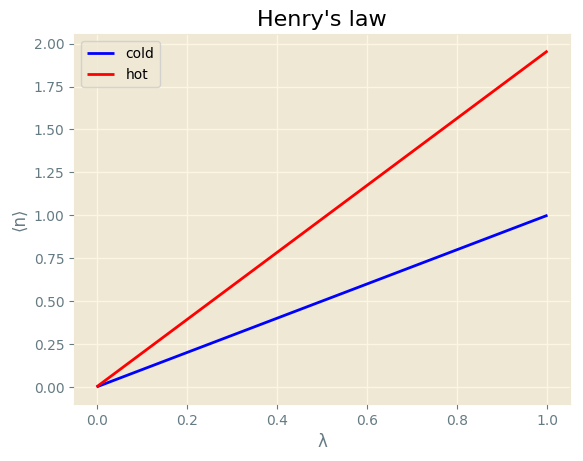

MORF material with:
	δ = 4.000
	ϵ♡ = -4.000
	ϵΔ = 0.000


PyObject Text(0.5, 1.0, "Henry's law")

In [28]:
λ = range(0.0, stop=1.0, length=100)
β = 10.0

material = Material(4.0, -4.0, 0.0)
print(material)

fig = plt.figure()
plot(λ, K(β, material) * λ, label="cold", color="b")
plot(λ, K(β*0.9, material) * λ, label="hot", color="r")
legend()
plt.xlabel("λ")
plt.ylabel("⟨n⟩")
plt.title("Henry's law")